 Implement metrics to compare two arbitrary distributions and apply
 to velocity profiles.
 Check the implementations for similarity by eye
 At the end we can add the velocity distribution similarity metric
 to our analysis (e.g. sobolnote.py)

In [15]:
import sys, os
join = lambda *x: os.path.abspath(os.path.join(*x))
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pili
import rtw
import _fj
import plotutils
import collections
import scipy.stats
import twanalyse
import pandas as pd
import parameters
import seaborn as sns



In [16]:
# paths
notedir, notename = os.path.split(os.getcwd())
notedir, notename
root = pili.root
# candidate to compare against
print("loading experiment data")
all_idx, all_trs = _fj.slicehelper.load_linearized_trs("all")
flipped, scores = _fj.redefine_poles(all_trs)
reference_idx = _fj.load_subset_idx()
reftrs = {}
for key, subidx in reference_idx.items():
    reftrs[key] = [all_trs[idx] for idx in subidx]

print("finished")


 10%|▉         | 298/3113 [00:00<00:00, 2972.37it/s]

loading experiment data


100%|██████████| 3113/3113 [00:01<00:00, 2142.74it/s]
/home/dan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dan/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


flipped 631/3113 tracks (20.3%)
finished


In [17]:
# simulation
angle1d_dir = join(root, "../run/new/angle_smoothed/range_pbrf")
simdata = collections.OrderedDict()
simdata[angle1d_dir] = rtw.DataCube(target=angle1d_dir)


In [18]:
# config
histstyle = {'rwidth': 0.9}


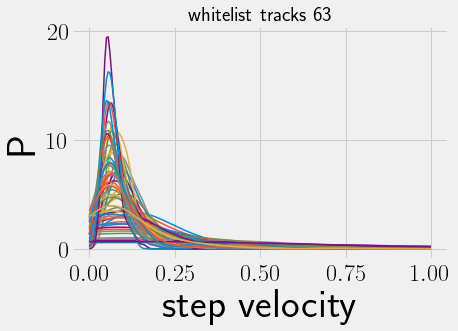

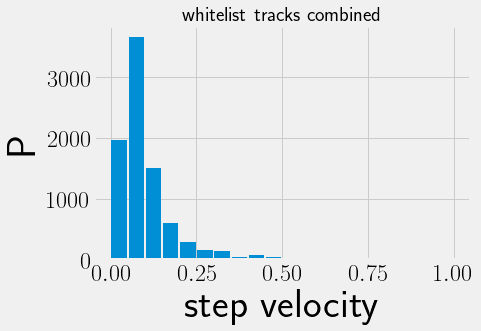

In [19]:
# plot individual track and combined distributions
fig,ax = plt.subplots(figsize=(6,4))
vellst = []
xlim = (0,1.0)
ax.set_title("whitelist tracks {}".format(len(reftrs["top"])))
for tr in reftrs["top"]:
    _vel = tr.get_step_speed()
    vellst.append(_vel)
    plotutils.ax_kdeplot(ax, _vel, xlims=xlim)
    ax.set_xlabel("step velocity")
    ax.set_ylabel("P")

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title("whitelist tracks combined")
ref_vel = np.concatenate(vellst)
ax.hist(ref_vel, bins=20, range=xlim, **histstyle)
ax.set_xlabel("step velocity")
ax.set_ylabel("P")

plt.show()


DataCube inspected directories at --> /home/dan/usb_twitching/run/new/angle_smoothed/range_pbrf
parameters: ['anchor_angle_smoothing_fraction']
with shape: [10]
with basis: 
anchor_angle_smoothing_fraction = [0.031, 0.062, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
<--
nsteps [284, 519, 962, 1467, 1958, 2342, 2537, 2658, 2671, 2702]


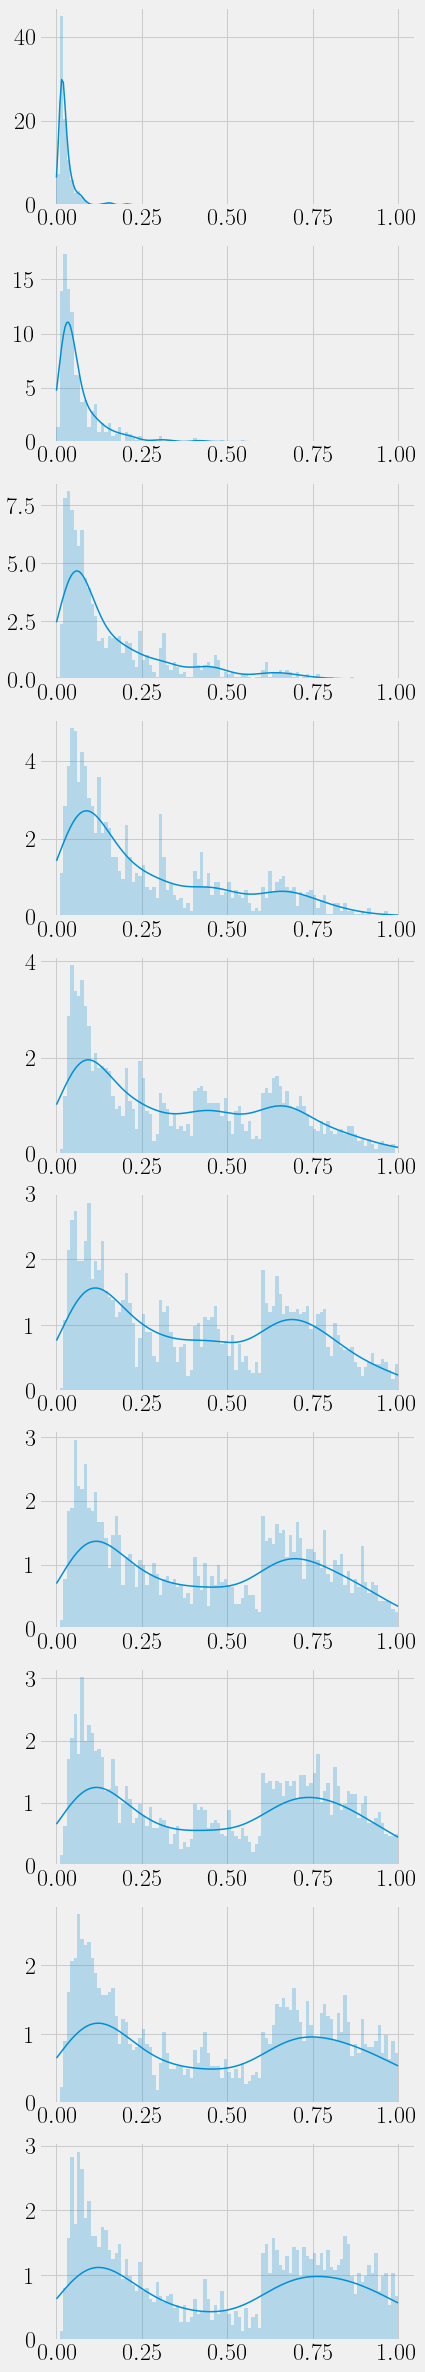

In [20]:
# plot velocity distributions for this 1d search
import readtrack
dc = list(simdata.values())[0]
print(str(dc))
trdata = dc.autocalculate(readtrack.trackset)
trdata = [[_fj.linearize(tr) for tr in trs] for trs in trdata]
vel = [np.concatenate([tr.get_step_speed() for tr in trs]) for trs in trdata]
nsteps = [np.sum([len(tr.step_idx) for tr in trs]) for trs in trdata]
print("nsteps", nsteps)
basis = dc.basis[0]

n = len(basis)
fig, axes = plt.subplots(n, figsize=(6,n*4))
# for i, value in list(enumerate(basis))[3:]:
for i, ax in enumerate(axes):
    plotutils.ax_kdeplot(ax, vel[i], xlims=xlim ,hist=True)


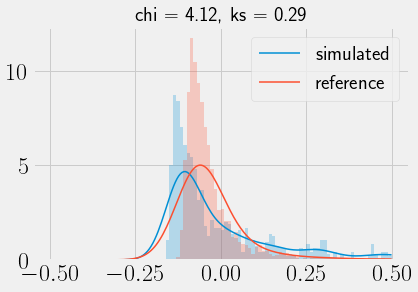

In [21]:
# superimise one simulated trajectory with the reference data
# def mean(x): return scipy.stats.trim_mean(x, 0.025)
mean = np.mean

def plot_similarity(ax, sim_vel, ref_vel):
    v1 = sim_vel - mean(sim_vel)
    v2 = ref_vel - mean(ref_vel)
    show_hist = True
    plotutils.ax_kdeplot(ax, v1, xlims=(-0.5,0.5), hist=show_hist)
    plotutils.ax_kdeplot(ax, v2, xlims=(-0.5,0.5), hist=show_hist)
    ax.legend(["simulated", "reference"])
    ks_statistic, pvalue = scipy.stats.ks_2samp(v1, v2)
    chi = twanalyse.chisquare(v1, v2)
    ax.set_title("chi = {:.2f}, ks = {:.2f}".format(chi, ks_statistic))

# test
i = 2
fig, ax = plt.subplots(figsize=(6,4))
plot_similarity(ax, vel[i], ref_vel)


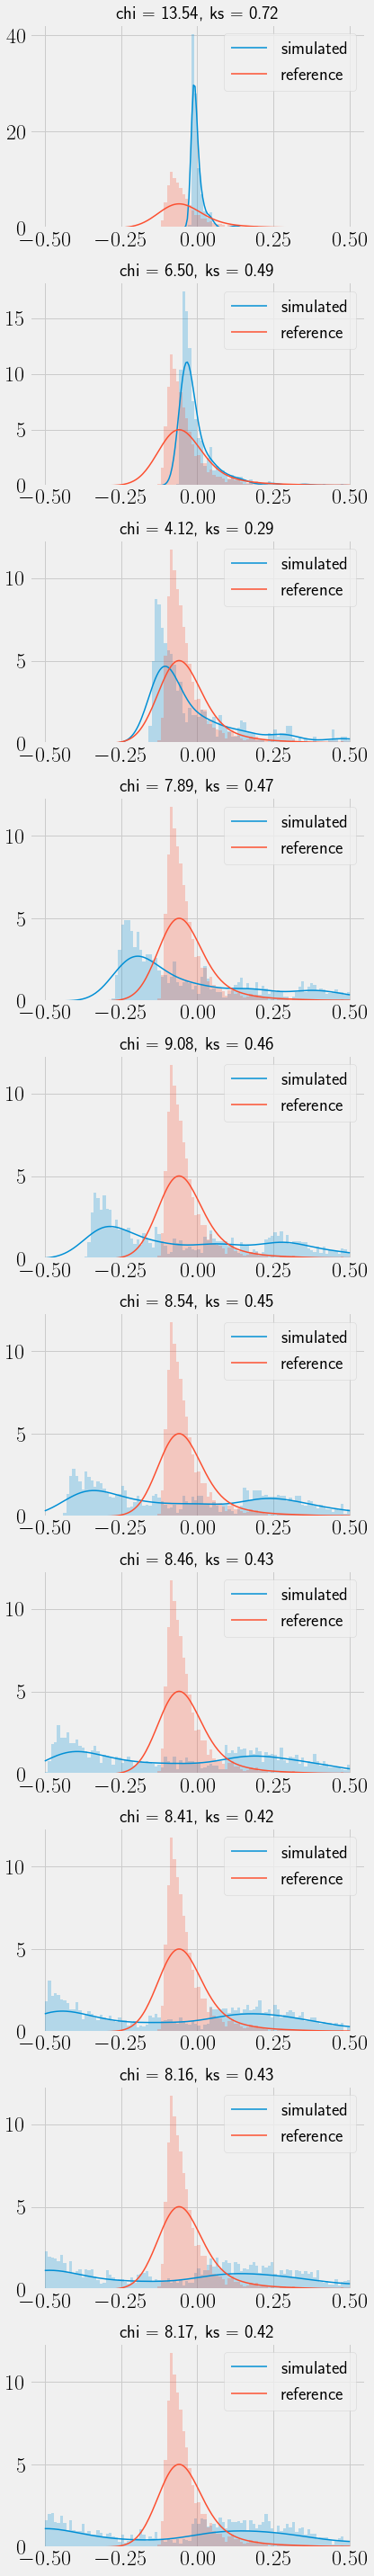

In [22]:
# superimpose simulated data on reference data for the whole 1d range

n = len(basis)
fig, axes = plt.subplots(n, figsize=(6,n*4))
# for i, value in list(enumerate(basis))[3:]:
for i, ax in enumerate(axes):
    plot_similarity(ax, vel[i], ref_vel)
plt.tight_layout()


 If we need a reference for what these similarity numbers actually
 mean we can check back on this notebook
 We should be ready to add these metrics to our summary statistics

In [23]:
# switch over to searching sobol dataset for the closest examples
import sobol
import twutils
simdir = "/home/dan/usb_twitching/run/b2392cf/cluster/sobol_01"
lookup = sobol.read_lookup(simdir)
problem = sobol.read_problem(simdir)
twutils.print_dict(problem)
_ , lduid = sobol.collect([], targetdir=simdir, alldata=True)


{
	"num_vars": 6,
	"names": [
		"k_ext_off",
		"dwell_time",
		"pilivar",
		"anchor_angle_smoothing_fraction",
		"k_spawn",
		"k_resample"
	],
	"bounds": [
		[
			0.2,
			1.0
		],
		[
			0.5,
			3.0
		],
		[
			1.0,
			20.0
		],
		[
			0.125,
			1.0
		],
		[
			0.5,
			5.0
		],
		[
			1.0,
			10.0
		]
	]
}


In [24]:
# load exp data
def _load_subset_speed():
    distrib = {}
    for name, ltrs in _fj.load_subsets().items():
        distrib[name] = np.concatenate([ltr.get_step_speed() for ltr in ltrs])
    return distrib
ref_vel = _load_subset_speed()


100%|██████████| 175/175 [00:00<00:00, 5294.04it/s]


In [25]:

subsets = reference_idx.keys()
# scores = ['fanjin.%s.chi' % subset for subset in reference_idx.keys()]
scores = ['fanjin.%s.ks_statistic' % subset for subset in reference_idx.keys()]
Yf = sobol.collect_obs(lookup, lduid, subsets, scores)
def sortscore(problem, lookup, Yf, scores):
    # need to sort each column seperately, can't do this in one dataframe
    # construct a dataframe with cols [i, simulation_index, score] for each subset
    paramlist = problem["names"]
    sortdf = {}
    for subset, data in Yf.items():
        sortidx = np.argsort(data)
        udir = [lookup[0][idx] for idx in sortidx]
        _cols = {"index": sortidx, "dir": udir, "score": data[sortidx]}   
        _parlist = zip(problem["names"],  zip(*[lookup[1][_u] for _u in udir]))
        _cols.update({k:v for k, v in _parlist})
        _df = pd.DataFrame(_cols)
        sortdf[subset] = _df
    return sortdf
sortdf = sortscore(problem, lookup, Yf, scores)
sortdf["top"]


,index,dir,score,k_ext_off,dwell_time,pilivar,anchor_angle_smoothing_fraction,k_spawn,k_resample
0,5599,_u_4BvpMFSM,0.119646,0.451563,1.012695,1.185547,0.157471,4.323242,5.025391
1,5490,_u_bjwAuQOL,0.125704,0.357813,1.950195,2.669922,0.160889,3.602539,9.103516
2,5618,_u_cEN2qG75,0.126801,0.682813,2.555664,3.263672,0.184814,4.586914,8.259766
3,9935,_u_mc0orhHg,0.127497,0.232031,1.767090,6.733398,0.142944,4.248535,7.565430
4,9164,_u_7yd0LsJx,0.131379,0.250781,1.488770,13.747070,0.163452,4.283691,8.338867
...,...,...,...,...,...,...,...,...,...
14331,5,_u_SyQdaakH,0.819537,0.200000,0.500000,1.000000,0.125000,0.500000,1.000000
14332,751,_u_GM4vF92B,0.820310,0.712500,0.695312,18.515625,0.138672,0.992188,5.359375
14333,11728,_u_1179ubjo,0.822192,0.633594,2.738770,19.350586,0.125854,1.005371,9.727539
14334,7,_u_L9q4zFIY,0.840073,0.200000,0.500000,1.000000,0.125000,0.500000,1.000000


In [26]:
# sync target data from cluster here in notebook
from sobol import sync_directory
best = sortdf["top"].iloc[0]


In [27]:
mpl.rcParams["text.latex.preamble"] = r'\usepackage{booktabs}'
histstyle = {"stat":"density", "common_norm": False, "element":"step"}
def plot_superimposed(dfrow, subset, simdir, histstyle=histstyle):
    target = join(simdir, dfrow["dir"])
    if not os.path.exists(join(target, "data/")):
        output = sync_directory(target)
    ltrs = twanalyse.get_linearised_data(ddir=target)
    lvel = np.concatenate([ltr.get_step_speed() for ltr in ltrs])
    xlim = (0,1.2)
    data = {"sim": lvel, subset: ref_vel[subset]}
    fig, ax = plt.subplots()
    sns.histplot(data, binrange=xlim, ax=ax, **histstyle)
    ax.text(.5,.5, dfrow.to_latex().replace('\n', ' '),
        transform=ax.transAxes, fontsize=20)
    ax.set_xlabel("$\mu ms^{-1}$")
    return ax

def plot_subset_best(sortdf, simdir):
    for subset in sortdf.keys():
        i = 0
        best = sortdf[subset].iloc[i]
        plot_superimposed(best, subset, simdir, histstyle=histstyle)

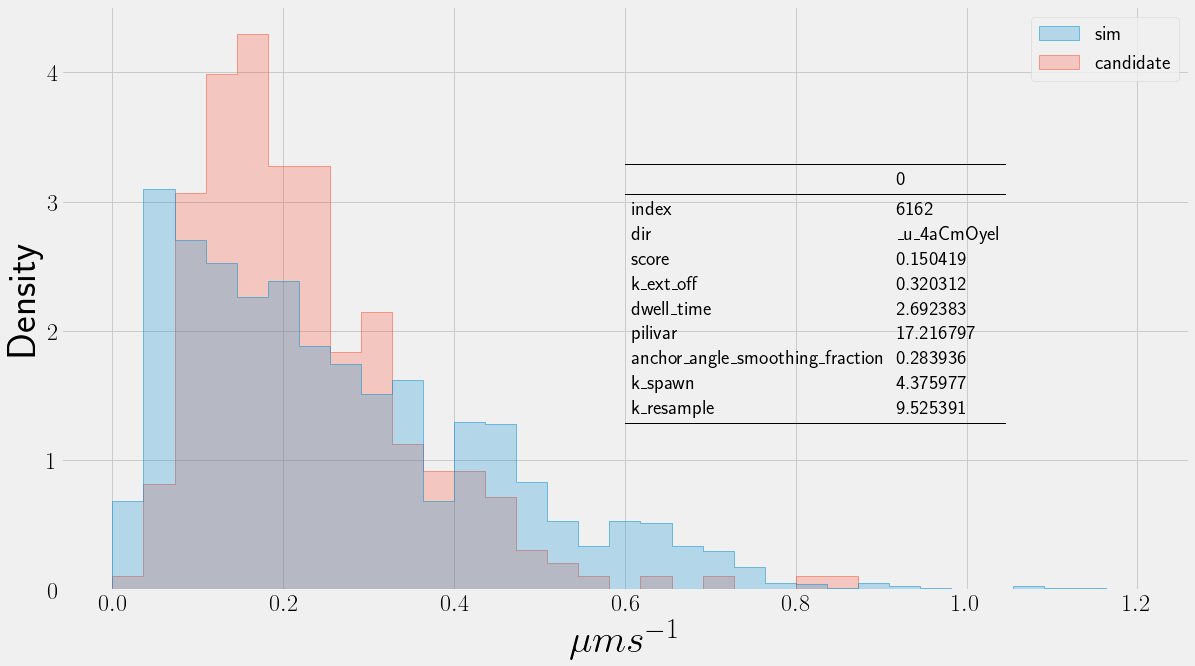

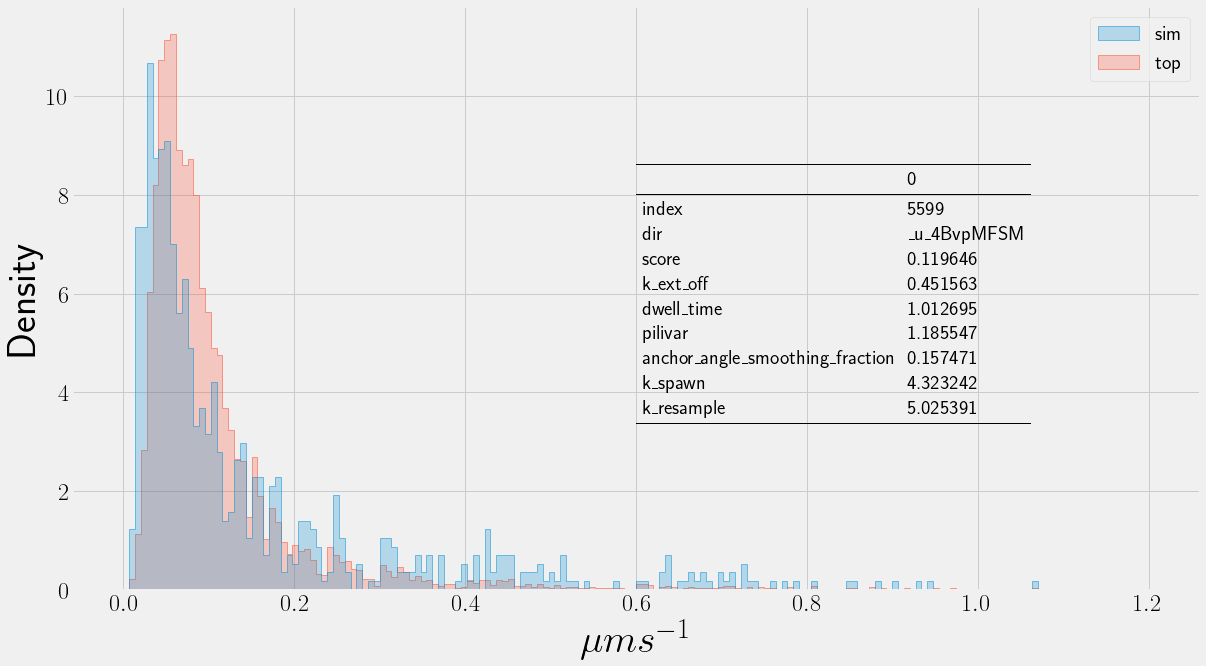

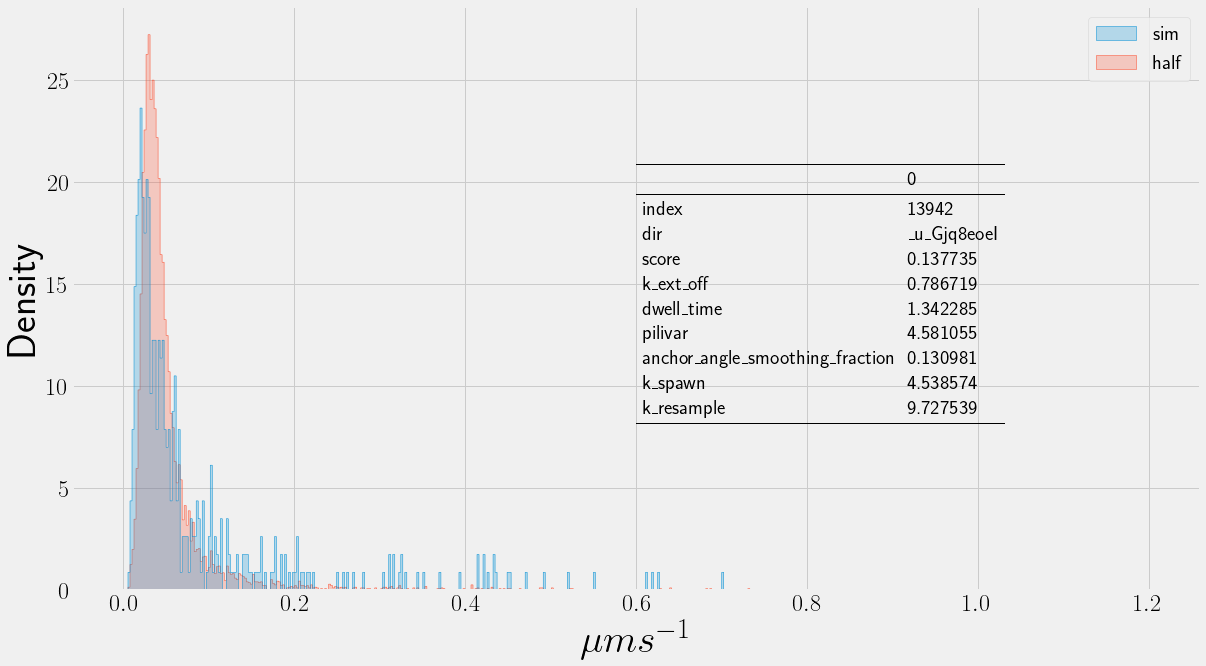

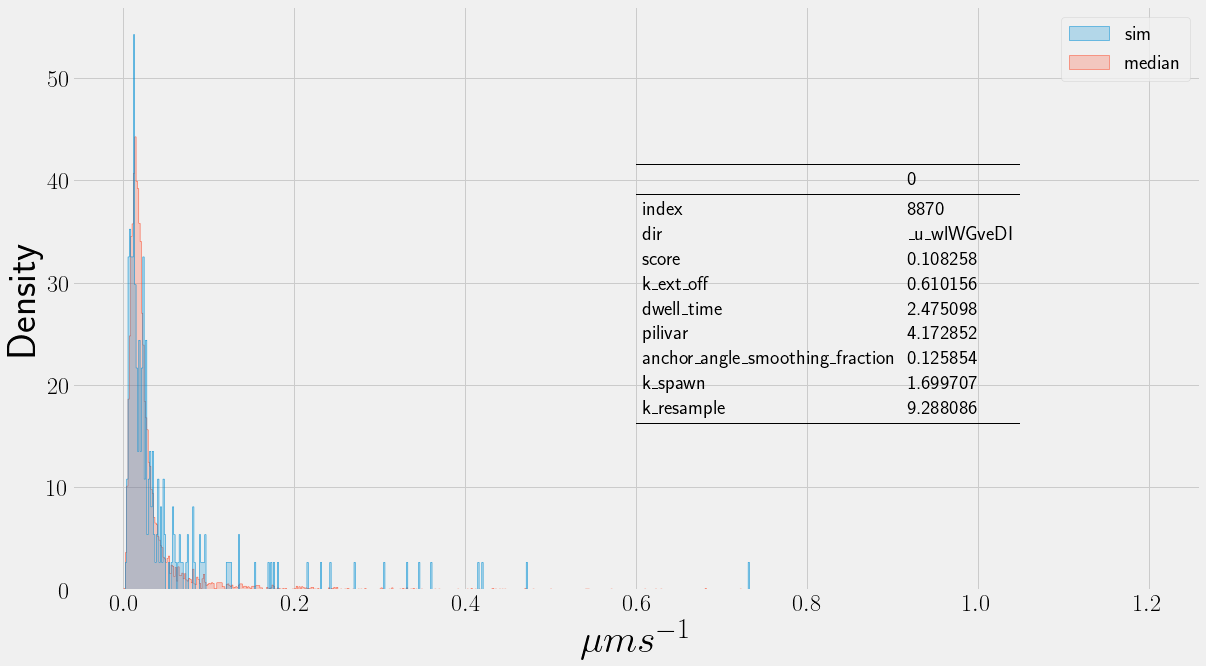

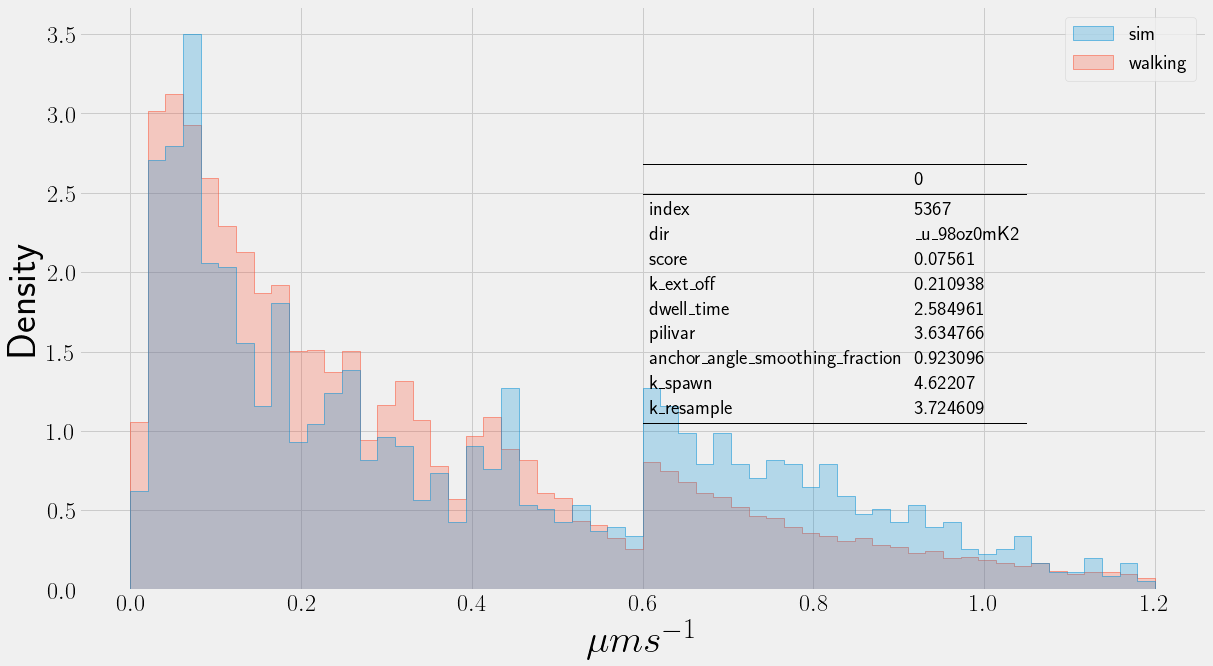

In [28]:
plot_subset_best(sortdf, simdir)


In [29]:
use_chi = False
if use_chi:
    chi_scores = ['fanjin.%s.chi' % subset for subset in reference_idx.keys()]
    chi_Yf = sobol.collect_obs(lookup, lduid, subsets, chi_scores)
    chi_sortdf = sortscore(problem, lookup, chi_Yf, chi_scores)
    chi_sortdf["candidate"]

In [30]:
if use_chi:
    plot_subset_best(chi_sortdf, simdir)


In [31]:
# It's clear our chi similarity totally fails for "top" and "candidate" 
# but we know better matches exist because the ks_statistic works much better
import scipy.stats
check_chi = False
if check_chi:
    _best = chi_sortdf["top"].iloc[0]
    res = 100
    ltrs = twanalyse.get_linearised_data(ddir=join(simdir, _best["dir"]))
    lvel = np.concatenate([ltr.get_step_speed() for ltr in ltrs])
    ref = ref_vel["top"]

In [32]:
if check_chi:
    v1 = lvel - np.mean(lvel)
    v2 = ref - np.mean(ref)
    print("mean", np.mean(lvel), np.mean(ref))
    _q = 0.050 # vary this
    xn1, xm1 =  np.quantile(v1, _q), np.quantile(v1, 1.0 - _q)
    xn2, xm2 =  np.quantile(v2, _q), np.quantile(v2, 1.0 - _q)
    xn, xm = min(xn1, xn2), max(xm1, xm2)
    print(xn1, xm1)
    print(xn2, xm2)
    print("xlims", xn, xm)
    mspace = np.linspace(xn, xm, res)
    # method = "scott"
    def method(self):
        div_f = 4.0 # vary this
        return np.power(self.neff, -1./(self.d+4)) / div_f
    kde1 = scipy.stats.gaussian_kde(v1, bw_method=method)
    kde2 = scipy.stats.gaussian_kde(v2, bw_method=method)
    pde1 = kde1.evaluate(mspace)
    pde2 = kde2.evaluate(mspace)
    plt.plot(mspace, pde1, label="")
    plt.plot(mspace, pde2)
    chisquared = np.sum((pde2 - pde1)**2/(pde1 + pde2))
    print("chi", np.sqrt(chisquared))

    fig, ax = plt.subplots()
    sns.histplot({"sim":v1, "top":v2}, binrange=(xn, xm), **histstyle)


 the chi metric is failing because the bandwidth is too large
 reducing by a factor 4 works well for this example but it may make the other
 examples worse (?)
 until we can figure out a more robust method, put trust in ks_statistic instead

In [33]:
simdir = "/home/dan/usb_twitching/run/5bfc8b9/cluster/sobol_walking"
lookup = sobol.read_lookup(simdir)
problem = sobol.read_problem(simdir)
print(problem)
_ , lduid = sobol.collect([], targetdir=simdir, alldata=True)

{'num_vars': 5, 'names': ['k_ext_off', 'dwell_time', 'pilivar', 'anchor_angle_smoothing_fraction', 'k_spawn'], 'bounds': [[0.2, 1.0], [0.5, 3.0], [1.0, 20.0], [0.125, 1.0], [0.1, 5.0]]}


In [34]:
import copy
_lookup = copy.deepcopy(lookup)
_lduid = copy.deepcopy(lduid)
for i, uid in reversed(list(enumerate(lookup[0]))):
    ld = lduid[uid]
    if ld.get("failed", False):
        print (uid, "failed", ld["failed_condition"])
        del _lduid[uid]
        del _lookup[1][uid]
        del _lookup[0][i]


_u_PYa0hZ5U failed step_condition
_u_ur0snpU4 failed step_condition


In [35]:
print(len(_lookup[0]), len(_lookup[1]), len(_lduid))

7166 7166 7166


In [36]:

scores = ['fanjin.%s.ks_statistic' % subset for subset in reference_idx.keys()]
Yf = sobol.collect_obs(_lookup, _lduid, subsets, scores)
sortdf = sortscore(problem, _lookup, Yf, scores)
sortdf["walking"]


,index,dir,score,k_ext_off,dwell_time,pilivar,anchor_angle_smoothing_fraction,k_spawn
0,1259,_u_cs5aMoaJ,0.123131,0.571875,0.587891,3.894531,0.962402,4.598047
1,886,_u_aYbIpLLa,0.130146,0.606250,0.910156,2.039062,0.924805,4.885156
2,3890,_u_Z1UINEcH,0.135629,0.489844,1.010254,2.206055,0.896606,3.186426
3,3739,_u_mN3rQZx8,0.136050,0.777344,0.736816,2.243164,0.964966,3.109863
4,1260,_u_WABi2BpQ,0.142264,0.678125,0.587891,3.894531,0.962402,4.598047
...,...,...,...,...,...,...,...,...
7161,3227,_u_Oqeg5VyP,0.684948,0.364063,2.965820,17.958984,0.769287,4.818164
7162,1325,_u_BJ2JoXne,0.684983,0.821875,2.619141,17.253906,0.142090,4.904297
7163,5186,_u_j1lsIOpn,0.685121,0.211719,2.602051,19.499023,0.968384,4.698535
7164,3229,_u_9VPkQBTJ,0.685987,0.864062,2.965820,15.435547,0.769287,4.818164


best simulation at  /home/dan/usb_twitching/run/5bfc8b9/cluster/sobol_walking/_u_cs5aMoaJ


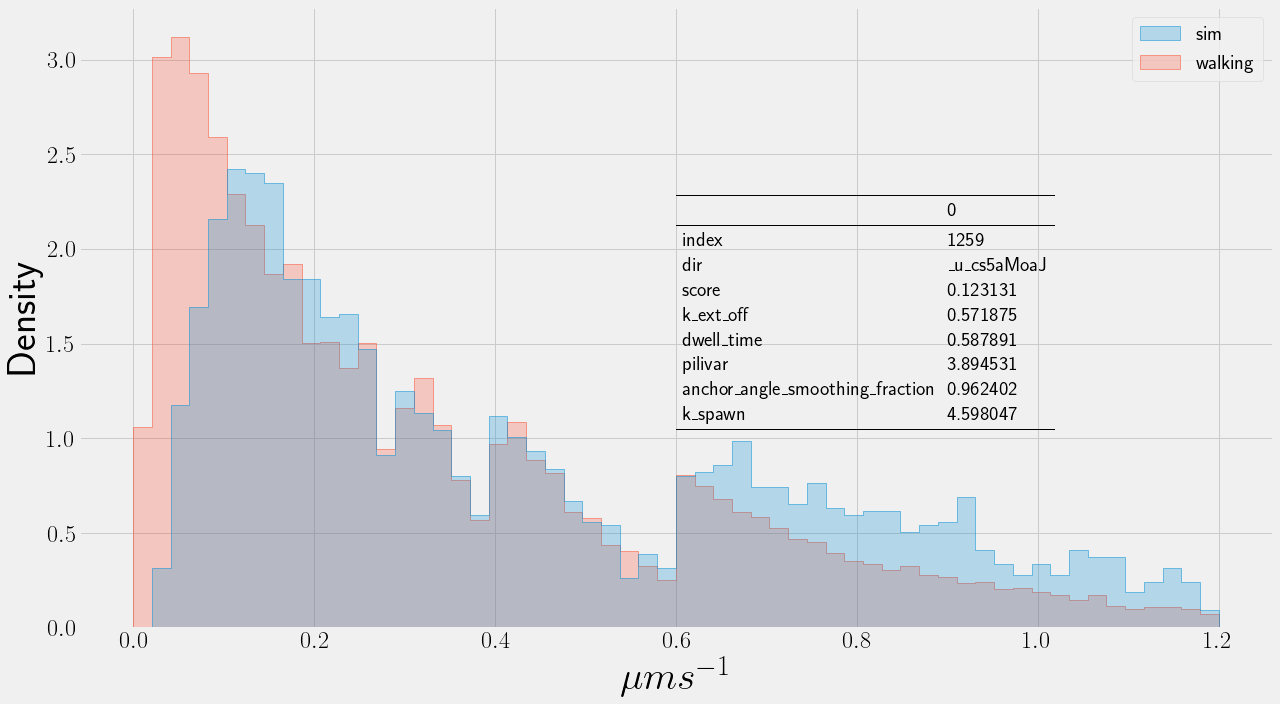

In [37]:
best = sortdf["walking"].iloc[0]
_style = copy.deepcopy(histstyle)
# _style["kde"] = True
ax = plot_superimposed(best, "walking", simdir, histstyle=_style)
plt.tight_layout()
plt.savefig("/home/dan/usb_twitching/notes/sensitivity/best_walking.png")
print("best simulation at ", join(simdir, best["dir"]))


 best simulation
 `/home/dan/usb_twitching/run/5bfc8b9/cluster/sobol_walking/_u_cs5aMoaJ`